In [419]:
import pandas as pd
import sys
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [332]:
class CustomerSegmentation:

    def __init__(self):
        """Initializes the CustomerSegmentation class."""
        self.data = None
    
    def load_data(self, file_path):
        """
        Loads a dataset from a CSV file into a pandas DataFrame
        Parameters:
        - file_path (str): Path to the CSV file.
        """
        try:
            self.data = pd.read_csv(file_path) # Load CSV into a DataFrame
        except FileNotFoundError: 
            print(f"Error: File not found at {file_path}. Exiting program.")
            sys.exit(1)

    def copy_df(self):
        """
        Creates a copy of the current instance with the same data.
        Returns:
        - A new instance of CustomerSegmentation with the same data
        """
        new_instance = CustomerSegmentation()
        new_instance.data = self.data.copy() if self.data is not None else None
        return new_instance
            
    def describe_data(self):
        """
        Provides a summary of the dataset
        """
        print("First Ten:\n", self.data.head(10))
        print("\nShape of the dataset:\n", self.data.shape)
        print("\nData basic info:\n", self.data.info())
        print("\nDescriptive statistics for numerical columns:\n", self.data.describe())
        print("\nColumns names:\n", self.data.columns)
        print("\nMissing Values:\n", self.data.isnull().sum())

    def basic_diagrams(self, columns=None):
        """
        Generates histograms and boxplots for numeric columns
        Parameters:
        -columns (list, optional): List of columns to visualize. Default to all numeric columns.
        """
        numeric_columns = columns or self.data.select_dtypes(include="number").columns
        print("HISTOGRAMS:\n")
        for i in numeric_columns:
            sns.histplot(data=self.data, x=i, kde=True, color='skyblue')
            plt.title(f"Histogram of {i}")
            plt.show()
        print("\nBOXPLOTS:\n")
        for i in numeric_columns:
            sns.boxplot(data=self.data, x=i, color='skyblue')
            plt.title(f"Box Plot of {i}")
            plt.show()

    def interquartile_range(self, column_name):
        """
        Calculates the interquartile range (IQR) and identifies outliers.
        Parameters:
        -column_name (str): Column to calculate IQR for.
        """
        Q1 = self.data[column_name].quantile(0.25)
        Q3 = self.data[column_name].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5*IQR
        upper_bound = Q3 + 1.5*IQR
        outliers = self.data.loc[(self.data[column_name] < lower_bound) | (self.data[column_name] > upper_bound)]
        print(f"lower_bound:\n {lower_bound}\n upper_bound:\n {upper_bound}\n Outliers:\n {outliers}\n")

    def correlation(self, columns=None):
        """
        Calculates and visualize the correlation matrix 
        -columns (list, optional): List of columns to visualize. Default to all numeric columns.
        """
        numeric_columns = columns or self.data.select_dtypes(include="number").columns
        corr_matrix = self.data[numeric_columns].corr()
        print(f"correlation matrix:\n {corr_matrix}\n")
        sns.heatmap(corr_matrix, annot=True)
        plt.title("Correlation Matrix")
        plt.show()

First Ten:
    CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
5           6  Female   22                  17                      76
6           7  Female   35                  18                       6
7           8  Female   23                  18                      94
8           9    Male   64                  19                       3
9          10  Female   30                  19                      72

Shape of the dataset:
 (200, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------       

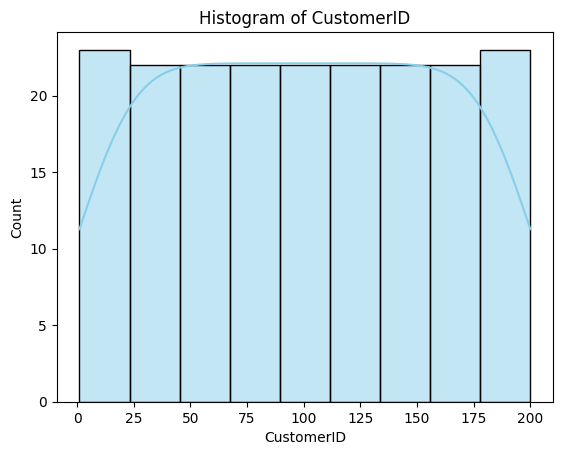

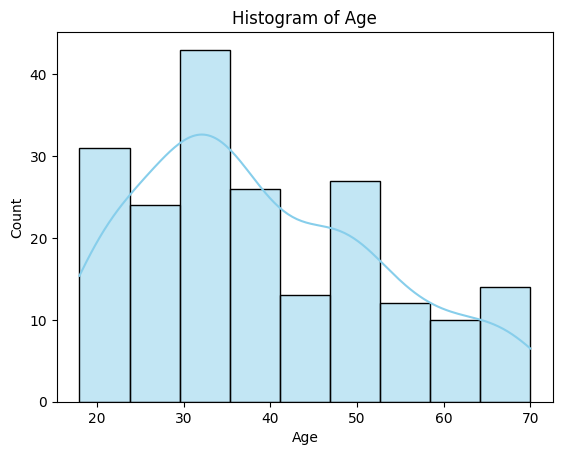

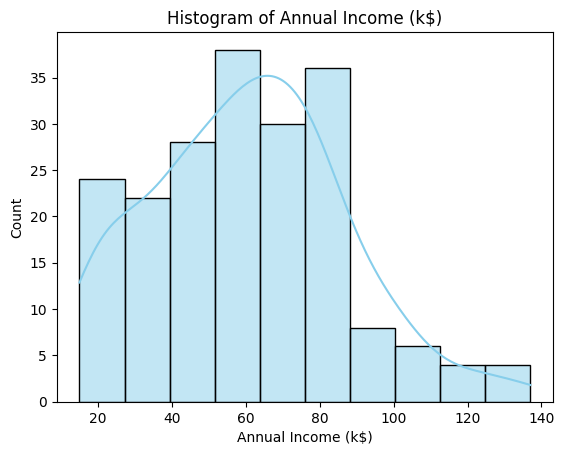

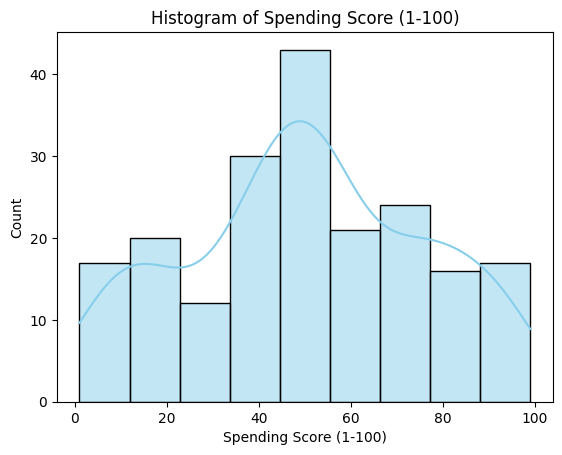


BOXPLOTS:



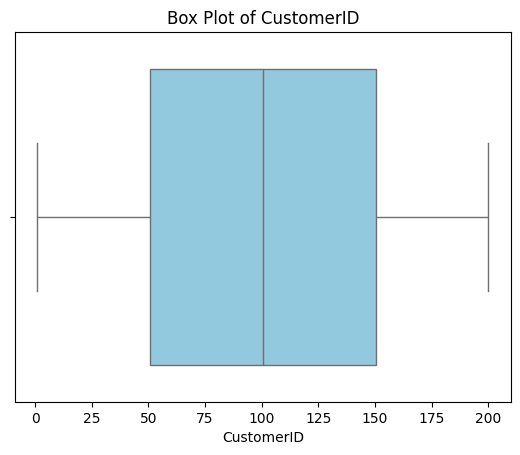

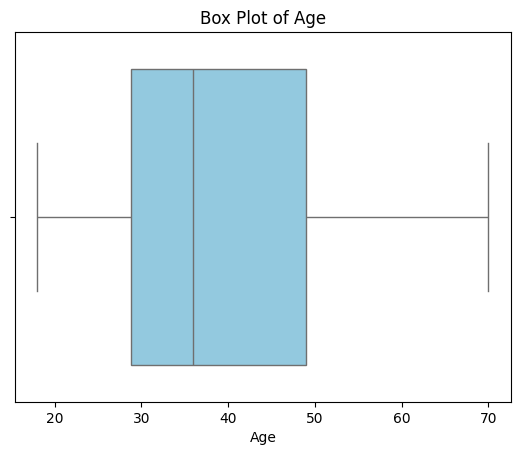

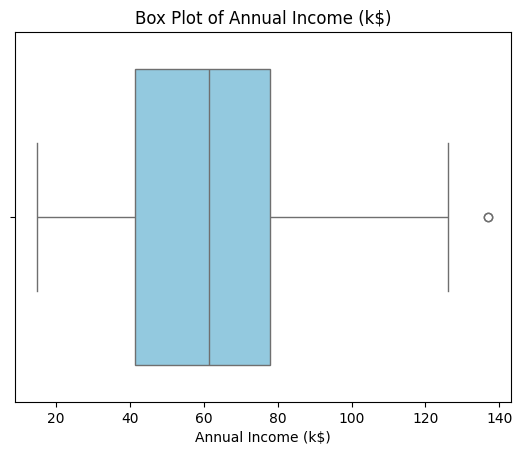

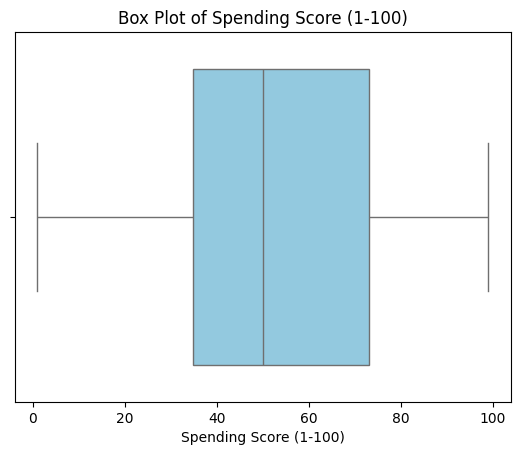

In [333]:
file_path = 'datasets/mall_customers.csv'
df = CustomerSegmentation()
df.load_data(file_path)
df.describe_data()
df.basic_diagrams()

In [334]:
# Rename a few of the column names
df.data = df.data.rename(columns={'Annual Income (k$)':'Annual Income', 'Spending Score (1-100)':'Spending Score'})

In [335]:
# Identify outliers using the interquartile_range function
df.interquartile_range('Annual Income')

lower_bound:
 -13.25
 upper_bound:
 132.75
 Outliers:
      CustomerID Gender  Age  Annual Income  Spending Score
198         199   Male   32            137              18
199         200   Male   30            137              83



In [336]:
df.interquartile_range('Spending Score')

lower_bound:
 -22.625
 upper_bound:
 130.375
 Outliers:
 Empty DataFrame
Columns: [CustomerID, Gender, Age, Annual Income, Spending Score]
Index: []



In [337]:
# Since the outliers in the 'Annual Incoming' column are close to the upper bound, I will apply the capping technique instead of removing them.
df.data['Annual Income'] = df.data['Annual Income'].clip(upper = 132)

In [338]:
# Drop the column CustomerID 
df.data = df.data.drop('CustomerID', axis=1)

In [428]:
# Encode gender to 0 and 1
label_encoder = LabelEncoder()
df.data['gender_encoding'] = label_encoder.fit_transform(df.data['Gender'])

correlation matrix:
                       Age  gender_encoding  Annual Income  Spending Score
Age              1.000000         0.060867      -0.011384       -0.327227
gender_encoding  0.060867         1.000000       0.054551       -0.058109
Annual Income   -0.011384         0.054551       1.000000        0.009934
Spending Score  -0.327227        -0.058109       0.009934        1.000000



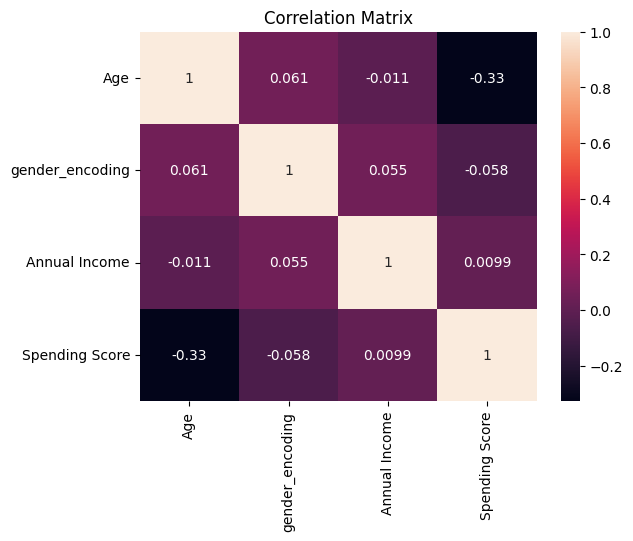

In [427]:
# Compute the correlation coefficient 
corr_columns = ['Age', 'gender_encoding', 'Annual Income', 'Spending Score']
df.correlation(corr_columns)

In [340]:
# Based on the correlation matrix and the heatmap i decided to include age, due to its moderate negative relationship and exclude annual income and gender, because these values indicates almost no relationship.
copied_df = df.copy_df()
copied_df.data = copied_df.data.drop(['Gender', 'Annual Income'], axis=1)

In [343]:
copied_df.describe_data()

First Ten:
    Age  Spending Score
0   19              39
1   21              81
2   20               6
3   23              77
4   31              40
5   22              76
6   35               6
7   23              94
8   64               3
9   30              72

Shape of the dataset:
 (200, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Age             200 non-null    int64
 1   Spending Score  200 non-null    int64
dtypes: int64(2)
memory usage: 3.3 KB

Data basic info:
 None

Descriptive statistics for numerical columns:
               Age  Spending Score
count  200.000000      200.000000
mean    38.850000       50.200000
std     13.969007       25.823522
min     18.000000        1.000000
25%     28.750000       34.750000
50%     36.000000       50.000000
75%     49.000000       73.000000
max     70.000000       99.000000

Columns n

In [410]:
class DataPreprocessor:

    def __init__(self, df):
        """Initializes the DataPreprocessor class."""
        self.data = df

    def standard_scaler(self):
        """
        Performs a Standard Scaling to the dataset
        Returns:
        - a new scaled dataframe
        """
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(self.data)
        return pd.DataFrame(scaled_data, columns=self.data.columns)

    def min_max_scaler(self):
        """
        Performs a MinMax Scaling to the dataset
        Returns:
        - a new scaled dataframe
        """
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(self.data)
        return pd.DataFrame(scaled_data, columns=self.data.columns)

    def elbow_method(self, max_k, data):
        """
        Performs the elbow method to the dataset and the call the plot_results_diagrams function to visualize the results
        Parameters:
        -max_k : The maximum number of clusters to form
        -data: The dataframe that the method is executed
        """
        k_values = range(1, max_k+1)
        inertia_values = []

        for k in k_values:
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(data)
            inertia_values.append(kmeans.inertia_)
            
        self.plot_results_diagrams(k_values, inertia_values, 'Elbow Method', 'Inertia')

    def silhouette_score(self, max_k, data):
        """
        Performs the silhouette score method to the dataset and the call the plot_results_diagrams function to visualize the results
        Parameters:
        -max_k : The maximum number of clusters to form
        -data: The dataframe that the method is executed
        """
        k_values = range(2, max_k+1)
        silhouette_scores = []

        for k in k_values:
            kmeans = KMeans(n_clusters=k, random_state=42)
            labels = kmeans.fit_predict(data)
            score = silhouette_score(data, labels)
            silhouette_scores.append(score)
        
        self.plot_results_diagrams(k_values, silhouette_scores, 'Silhouette Method', 'Silhouete Score')
            
    def plot_results_diagrams(self, k, values, method_name, ylabel):
        """
        Plots diagrams based on the parameters it receives
        Parameters:
        -k : The range of k values (xlabel)
        -values: The result values (ylabel)
        -method_name: The method's name that will be displayed in the title
        ylabel: The name of the ylabel
        """
        plt.figure(figsize=(8, 6))
        plt.plot(k, values, marker='o', linestyle='--', color='b')
        plt.title(f"{method_name} for Optimal K")
        plt.xlabel("Number of clusters(k)")
        plt.ylabel(ylabel)
        plt.xticks(k)
        plt.grid()
        plt.show()

In [411]:
# Initialize the class and perform standard scaling and min-max scaling
preprocessor = DataPreprocessor(copied_df.data)
standard_df = preprocessor.standard_scaler()
min_max_df = preprocessor.min_max_scaler()

In [412]:
standard_df

,Age,Spending Score
0,-1.424569,-0.434801
1,-1.281035,1.195704
2,-1.352802,-1.715913
3,-1.137502,1.040418
4,-0.563369,-0.395980
...,...,...
195,-0.276302,1.118061
196,0.441365,-0.861839
197,-0.491602,0.923953
198,-0.491602,-1.250054


In [413]:
min_max_df

,Age,Spending Score
0,0.019231,0.387755
1,0.057692,0.816327
2,0.038462,0.051020
3,0.096154,0.775510
4,0.250000,0.397959
...,...,...
195,0.326923,0.795918
196,0.519231,0.275510
197,0.269231,0.744898
198,0.269231,0.173469


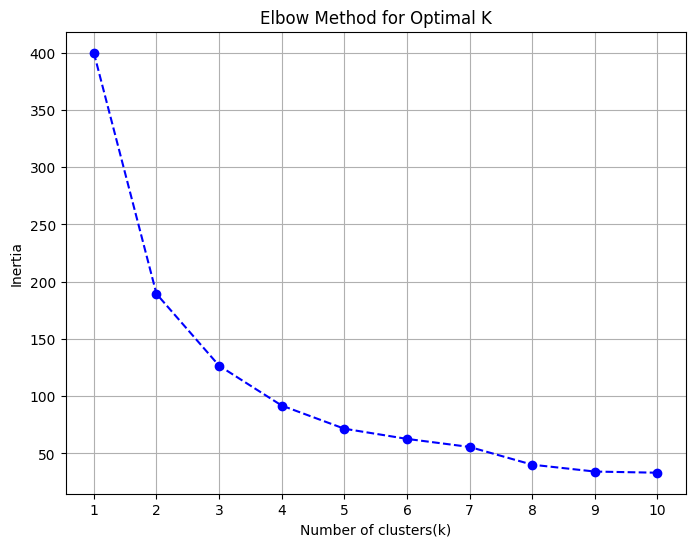

In [416]:
# Elbow Method for Standard Scaled Data
preprocessor.elbow_method(max_k=10, data=standard_df)

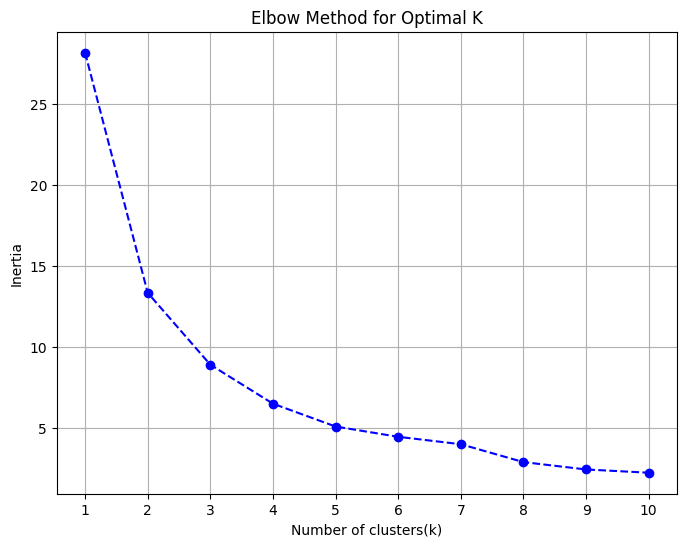

In [417]:
# Elbow Method for Min-Max Scaled Data
preprocessor.elbow_method(max_k=10, data=min_max_df)

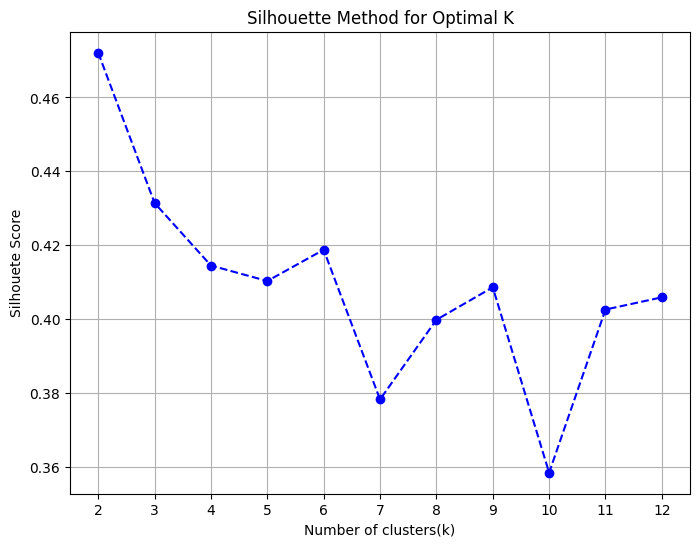

In [514]:
# Silhouette Score for Standard Scaled Data
preprocessor.silhouette_score(max_k=12, data=standard_df)

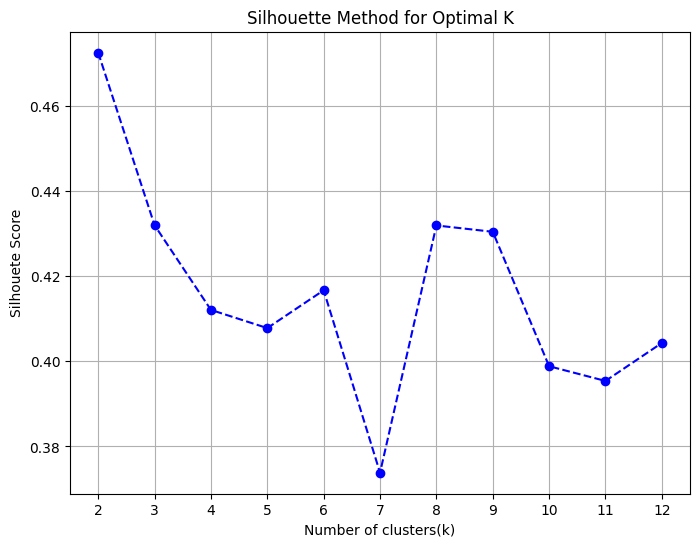

In [513]:
# Silhouette Score for Min-Max Scaled Data
preprocessor.silhouette_score(max_k=12, data=min_max_df)

In [496]:
class ClusteringProcess:

    def __init__(self,df):
        """Initializes the ClusteringProcess class."""
        self.data = df
        
    def kmeans_clustering(self, clusters, method='k-means++', init_num=10, iterations=300, label_title=''):
        """
        Performs KMeans clustering on the data.
        Parameters:
        - clusters: Number of clusters (k)
        - method: Method for initialization ('k-means++' or 'random')
        - init_num: Number of initializations
        - iterations: Maximum number of iterations
        -label_title: The title of the label
        """
        data_array = self.data.values
        kmeans = KMeans(
            n_clusters = clusters,
            init = method,
            n_init = init_num,
            max_iter = iterations,
            tol = 1e-4,
            random_state = 42
        )
        kmeans.fit(data_array)
        self.labels = kmeans.labels_
        self.centroids = kmeans.cluster_centers_
        self.inertia = kmeans.inertia_
        print("Cluster Centers:\n", self.centroids, '\n', "Labels:\n", self.labels, '\n', "Inertia:\n", self.inertia, '\n')
        self.two_d_clustering_diagram(label_title)

                  
    def two_d_clustering_diagram(self, label_title):
        """
        Visualizes the clustering results in 2D.
        Parameters:
        - label_title: Title of the clustering diagram.
        """
        plt.figure(figsize=(8,6))
        plt.scatter(self.data.iloc[:,0],
                    self.data.iloc[:,1],
                    c=self.labels,
                    cmap='viridis',
                    s=50,
                    label=label_title)

        plt.scatter(
                    self.centroids[:, 0],
                    self.centroids[:, 1],
                    s=200,
                    c='red',
                    marker='X',
                    label='Centroids'
                )
                
        plt.title(f"KMeans Clustering :{label_title}({self.data.columns[0]} vs {self.data.columns[1]})")
        plt.xlabel(f"{self.data.columns[0]}")
        plt.ylabel(f"{self.data.columns[1]}")
        plt.legend()
        plt.grid()
        plt.show()

Cluster Centers:
 [[ 0.70892251 -0.69939115]
 [-0.75277339  0.74265245]] 
 Labels:
 [1 1 0 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0
 0 1 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 0 1 0 1 1 0 0 1 0 1 0 0 0 0 0
 1 0 1 1 1 0 0 0 0 1 0 1 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1] 
 Inertia:
 189.38749033992428 



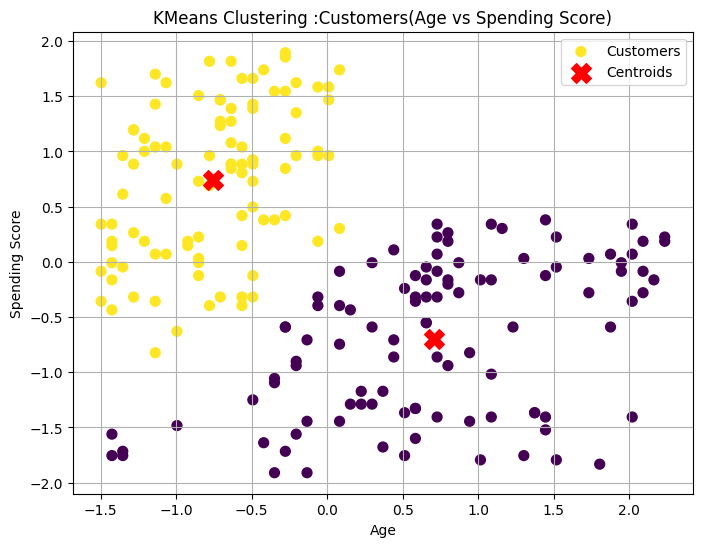

In [511]:
# Since Standard Scaling & Min Max Scaling yield almost the same results i will use the standard scaled data because age doesn't have a uniformly distribution and i don't want to compress the values into a small range [0-1].
# Moreover, after analyzing the results of the elbow method and the silhouette score, the optimal number of clusters appears to be 2.
clustering = ClusteringProcess(standard_df)
clustering.kmeans_clustering(clusters=2, label_title='Customers')

Cluster Centers:
 [[ 0.70892251 -0.69939115]
 [-0.75277339  0.74265245]] 
 Labels:
 [1 1 0 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0
 0 1 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 0 1 0 1 1 0 0 1 0 1 0 0 0 0 0
 1 0 1 1 1 0 0 0 0 1 0 1 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1] 
 Inertia:
 189.38749033992428 



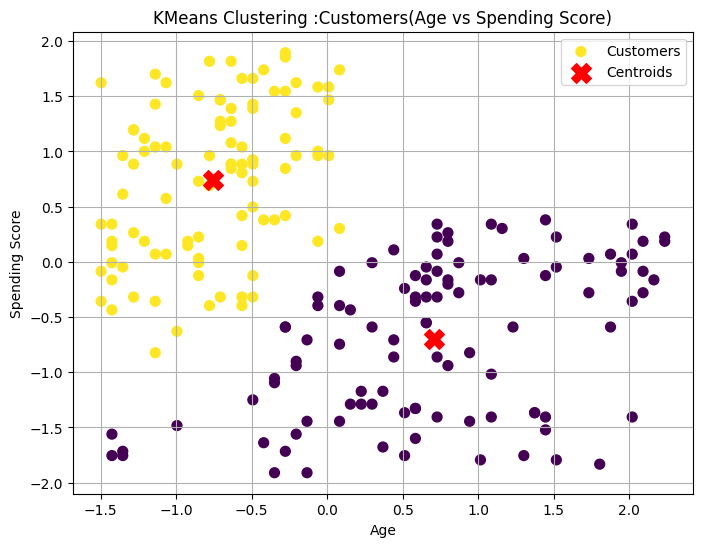

In [541]:
clustering.kmeans_clustering(clusters=2, method='random', init_num=15, iterations=350, label_title='Customers')

Cluster Centers:
 [[ 0.70892251 -0.69939115]
 [-0.75277339  0.74265245]] 
 Labels:
 [1 1 0 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0
 0 1 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 0 1 0 1 1 0 0 1 0 1 0 0 0 0 0
 1 0 1 1 1 0 0 0 0 1 0 1 1 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1] 
 Inertia:
 189.38749033992428 



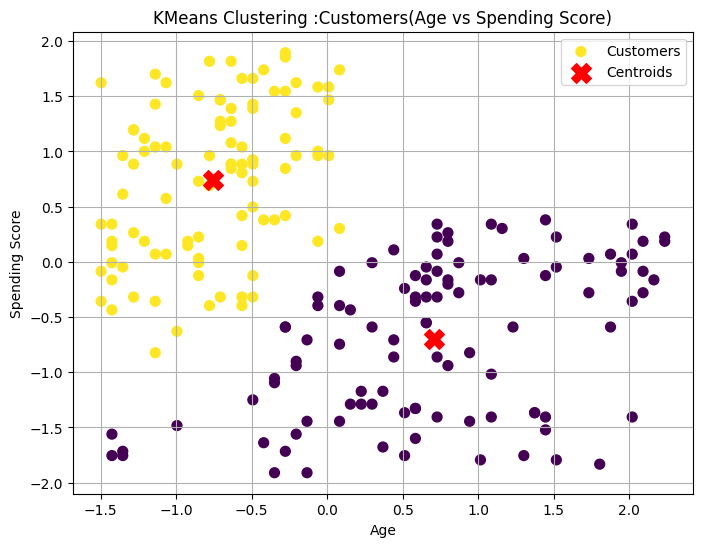

In [542]:
clustering.kmeans_clustering(clusters=2, method='k-means++', init_num=30, iterations=400, label_title='Customers')

In [543]:
# Concatenate  the original dataframe and the scaled one to compare them and draw a conclusion
comparison_df = pd.concat([copied_df.data, standard_df], axis=1)
comparison_df.columns = ['Age', 'Spending Score', 'Scaled Age', 'Scaled Spending Score']
comparison_df.query("`Scaled Age` >= -1.5 & `Scaled Age` <= -0.5").sort_values('Age', ascending=True)

,Age,Spending Score,Scaled Age,Scaled Spending Score
33,18,92,-1.496335,1.622741
91,18,41,-1.496335,-0.357158
65,18,59,-1.496335,0.341630
114,18,48,-1.496335,-0.085407
0,19,39,-1.424569,-0.434801
...,...,...,...,...
163,31,93,-0.563369,1.661563
4,31,40,-0.563369,-0.395980
43,31,61,-0.563369,0.419273
133,31,71,-0.563369,0.807488


In [544]:
comparison_df.query("`Scaled Age` >= -0.5 & `Scaled Age` <= 0.0").sort_values('Age', ascending=True)

,Age,Spending Score,Scaled Age,Scaled Spending Score
198,32,18,-0.491602,-1.250054
143,32,87,-0.491602,1.428633
147,32,74,-0.491602,0.923953
94,32,42,-0.491602,-0.318337
197,32,74,-0.491602,0.923953
69,32,47,-0.491602,-0.124229
141,32,93,-0.491602,1.661563
137,32,73,-0.491602,0.885132
169,32,63,-0.491602,0.496916
181,32,86,-0.491602,1.389812


# After applying the KMeans algorithm and analyzing the data, the conclusion is that customers in the 18-38 age range, particularly those between 18-31, have the highest spending score.